In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("afg.csv",sep=";")

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shapefile as shp

In [4]:
def f(data):
    if data['POPULATION']>1000000:
        val = data['POPULATION']/1000
    elif data['POPULATION'] > 100000:
        val = data['POPULATION']/700
    elif data['POPULATION'] > 10000:
        val = data['POPULATION']/300
    elif data['POPULATION'] > 1000:
        val = data['POPULATION']/80
    elif data['POPULATION'] > 100:
        val = data['POPULATION']/90
    elif data['POPULATION'] > 10:
        val = data['POPULATION']/9.99
    else:
        val = 1
    return val

data["weight_pop"]=data.apply(f, axis=1)

In [5]:
def g(data):
    if data['POPULATION']>1000000:
        val = "#b8860b"
    elif data['POPULATION'] > 100000:
        val = "#ffd700"
    elif data['POPULATION'] > 10000:
        val = "#eedd82"
    elif data['POPULATION'] > 1000:
        val = "#eee8aa"
    elif data['POPULATION'] > 100:
        val = "#ffffe0"
    elif data['POPULATION'] > 10:
        val = "#ffffe0"
    else:
        val = "green"
    return val

data["weight_pop_col"]=data.apply(g, axis=1)

In [6]:
data["weight_long"]=data.LON_X*data.POPULATION
data["weight_lat"]=data.LAT_Y*data.POPULATION

In [7]:
groups=data.groupby(["PROV_CODE"])
region=pd.DataFrame(columns=['PROV_CODE','POP','LANG_CODE','LON_X','LAT_Y','weight_long','weight_lat'])
i=0
for key,df in groups:
    region.loc[i]=[key,df['POPULATION'].sum(),df["LANG_CODE"].value_counts().idxmax(),df["LON_X"].mean(),df['LAT_Y'].mean(),
                  df['weight_long'].sum()/df['POPULATION'].sum(),df['weight_lat'].sum()/df['POPULATION'].sum()]
    i=i+1

In [8]:
groups=data.groupby(["DIST_CODE"])
district=pd.DataFrame(columns=['DIST_CODE','POP',"Number_centroids","PEOPLE_per_centroids",'LANG_CODE','LON_X','LAT_Y','weight_long','weight_lat'])
i=0
for key,df in groups:
    district.loc[i]=[key,df['POPULATION'].sum(),df['DIST_CODE'].count(),df['POPULATION'].sum()/df["DIST_CODE"].count(),df["LANG_CODE"].value_counts().idxmax(),df["LON_X"].mean(),df['LAT_Y'].mean(),
                  df['weight_long'].sum()/(df['POPULATION'].sum()+1),df['weight_lat'].sum()/(df['POPULATION'].sum()+1)]
    i=i+1

In [9]:
data["weight_pop"];

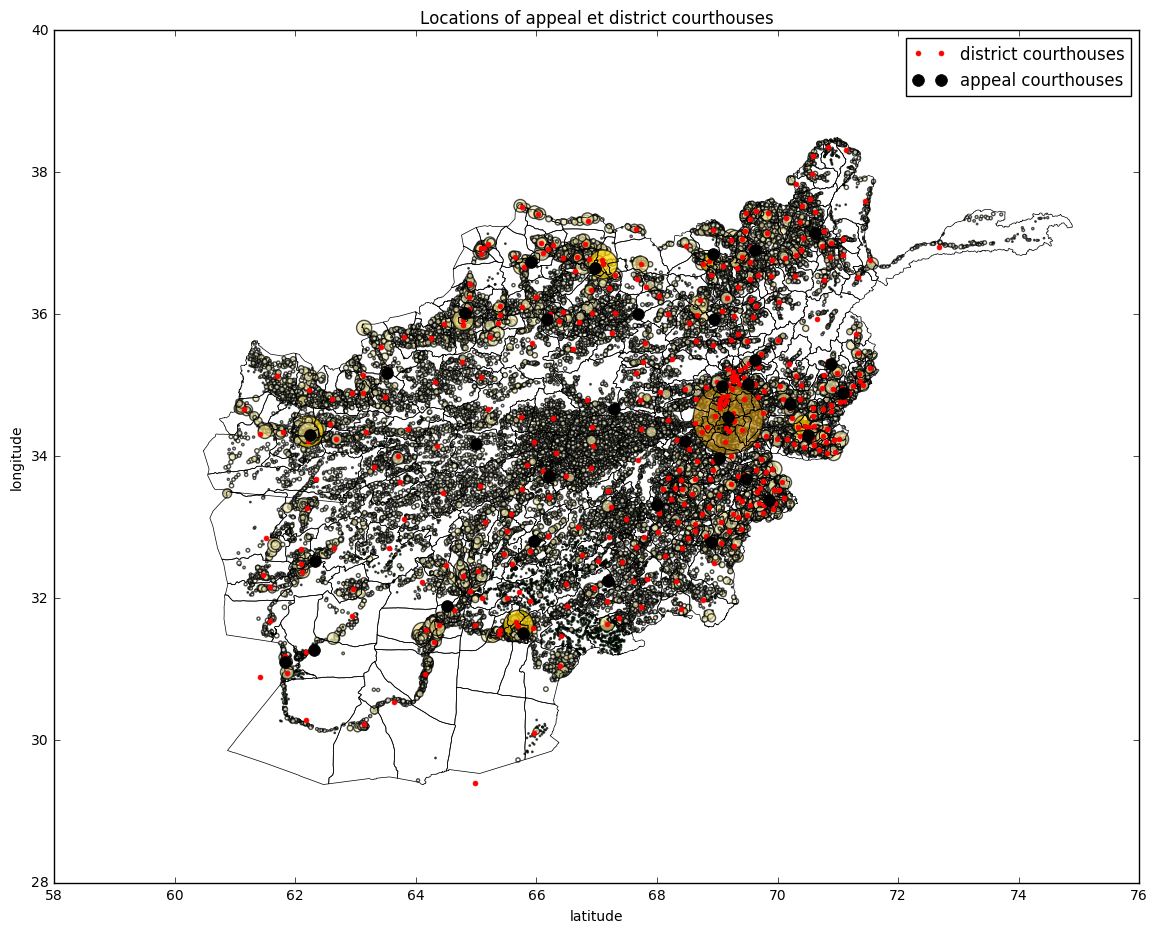

In [10]:
sf = shp.Reader("Afghanistan_Districts","rb")

district=district[district['weight_lat']>0]
region=region[region['weight_lat']>0]

plt.figure()
plt.figure(figsize=(14,11))


for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color='k',linewidth=0.5)


#plt.plot(data['LON_X'],data['LAT_Y'],alpha=0.7)
plt.scatter(data['LON_X'],data['LAT_Y'],s=data["weight_pop"],c=data["weight_pop_col"],label="",alpha=0.7)    
plt.plot(district['weight_long'], district['weight_lat'],".r",label='district courthouses',ms=7)
plt.plot(region['weight_long'], region['weight_lat'],".k",label='appeal courthouses',ms=17)
plt.title("Locations of appeal et district courthouses")
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.legend(loc='best')
plt.show()

In [11]:
def find_city(longitude, latitude, big_town):
    closest = 0
    centroid = big_town[["LON_X","LAT_Y"]].iloc[0]
    min_dis = (longitude - centroid[0])**2 + (latitude - centroid[1])**2 
    for i in range(1, big_town[["LON_X","LAT_Y"]].shape[0]):
        dis = (longitude - big_town[["LON_X","LAT_Y"]].iloc[i][0])**2 + (latitude - big_town[["LON_X","LAT_Y"]].iloc[i][1])**2 
        if dis < min_dis:
            min_dis = dis
            closest = i
            centroid = big_town[["LON_X","LAT_Y"]].iloc[i]
    return big_town["OBJECTID"].iloc[closest], centroid

In [12]:
centroid = [0,0]
min_dis = (3 - centroid[0])**2 + (8 - centroid[1])**2

In [13]:
groups=data.groupby(["DIST_CODE"])
district=pd.DataFrame(columns=['DIST_CODE','POP',"Number_centroids","PEOPLE_per_centroids",'LANG_CODE','LON_X','LAT_Y','weight_long','weight_lat'])
i=0
for key,df in groups:
    district.loc[i]=[key,df['POPULATION'].sum(),df['DIST_CODE'].count(),df['POPULATION'].sum()/df["DIST_CODE"].count(),df["LANG_CODE"].value_counts().idxmax(),df["LON_X"].mean(),df['LAT_Y'].mean(),
                  df['weight_long'].sum()/(df['POPULATION'].sum()+1),df['weight_lat'].sum()/(df['POPULATION'].sum()+1)]
    i=i+1

In [14]:
#the 399 districts
list_dist=district[district["DIST_CODE"]!=0]["DIST_CODE"].tolist()
list_dist=set(list_dist)
list_dist;

In [15]:
# Find out which small town is close to a given big town (samples!!)
data=data.sample(frac=0.4)
data_small=data[data["POPULATION"]<1000].sample(frac=0.1, replace=False);
data_big=data[data["POPULATION"]>999].sample(frac=0.1, replace=False);
new_small_data=pd.DataFrame(columns=["OBJECTID","which_big_town"])

k=0
for j in list_dist:
    length=data_small[data_small["DIST_CODE"]==j].shape[0]
    location_data = data_small[data_small["DIST_CODE"]==j][["LON_X","LAT_Y"]].as_matrix()
    #which_centroid = np.zeros(data_small[data_small["DIST_CODE"]==j].shape[0])
    if data_small[(data_small["DIST_CODE"]==j)].shape[0]!=0 and data_big[(data_big["DIST_CODE"]==j)].shape[0]!=0:
        for i in range(0,length):
            town, dummy = find_city(location_data[i][0], location_data[i][1], data_big[data_big["DIST_CODE"]==j])
            #new_small_data.loc[k]=[data_small["OBJECTID"].iloc[i], town]
            new_small_data.loc[k]=[data_small[data_small["DIST_CODE"]==j]["OBJECTID"].iloc[i], town]
            k=k+1
            #which_centroid[i], dummy = find_city(location_data[i][0], location_data[i][1], data_big[data_big["DIST_CODE"]==j][["LON_X","LAT_Y"]])
        #new_small_data[new_small_data]['which_big_town'] = which_centroid    #which town is it linked to

In [16]:
data_big["POPULATION"];

In [17]:
#check the result
print(new_small_data.shape[0],data_small.shape[0])


494 1621


In [18]:
new_data=pd.merge(new_small_data,data,on="OBJECTID",how="left")[["OBJECTID","which_big_town","POPULATION","LANGUAGE_","LANG_CODE","LON_X","LAT_Y"]]
new_data["weight_pop"]=new_data.apply(f, axis=1)
new_data["weight_pop_col"]=new_data.apply(g, axis=1)
new_data.shape[0]

494

In [19]:
new_data.head(5)

,OBJECTID,which_big_town,POPULATION,LANGUAGE_,LANG_CODE,LON_X,LAT_Y,weight_pop,weight_pop_col
0,10910.0,16931.0,143,Dari,1,65.2908,33.5053,1.588889,#ffffe0
1,17319.0,16931.0,198,Dari,1,64.8058,33.5393,2.200000,#ffffe0
2,11104.0,16931.0,172,Dari,1,65.3113,33.5936,1.911111,#ffffe0
3,17369.0,16931.0,426,Dari,1,65.1751,33.8540,4.733333,#ffffe0
4,10912.0,16931.0,70,Pashto,2,65.2066,33.4852,7.007007,#ffffe0


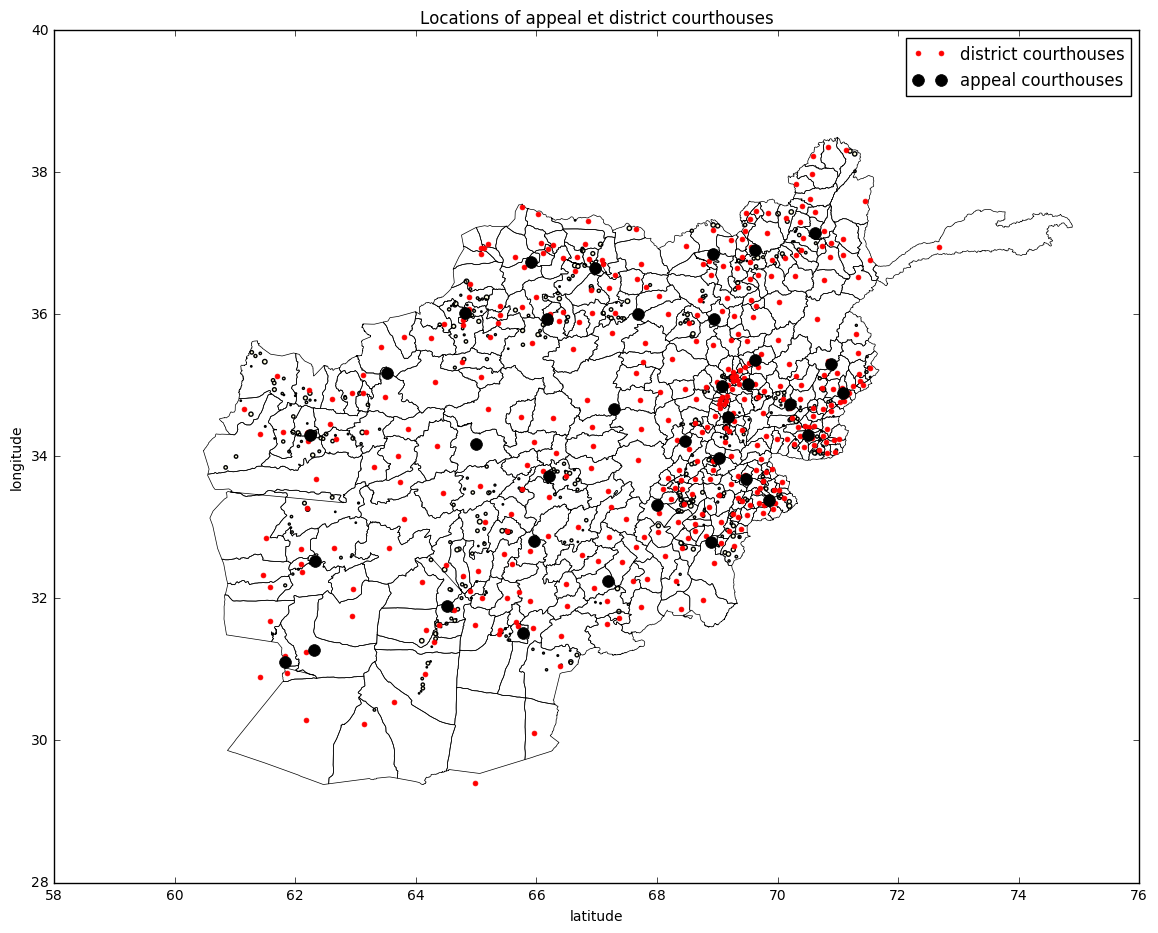

In [20]:
sf = shp.Reader("Afghanistan_Districts","rb")

district=district[district['weight_lat']>0]
region=region[region['weight_lat']>0]

plt.figure()
plt.figure(figsize=(14,11))


for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color='k',linewidth=0.5)


#plt.plot(data['LON_X'],data['LAT_Y'],alpha=0.7)
plt.scatter(new_data['LON_X'],new_data['LAT_Y'],s=new_data["weight_pop"],c=new_data["weight_pop_col"],label="",alpha=1)    
plt.plot(district['weight_long'], district['weight_lat'],".r",label='district courthouses',ms=7)
plt.plot(region['weight_long'], region['weight_lat'],".k",label='appeal courthouses',ms=17)
plt.title("Locations of appeal et district courthouses")
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.legend(loc='best')
plt.show()

In [21]:
new_data["isna"]=new_data["which_big_town"].apply(lambda x : pd.isnull(x))
new_data["which_big_town"].fillna(value=0,inplace=True)
new_data["new_town"]=new_data["isna"]*new_data["OBJECTID"]+new_data["which_big_town"]

In [22]:
new_data.shape[0]

494

In [23]:
print(len(new_data["POPULATION"]))

494


In [24]:
# groupby which_big_town,
# check the language spoken on this big town, add the population, keep the longitude, the latitude
groups=new_data.groupby(["which_big_town"])
bigtown=pd.DataFrame(columns=["which_big_town",'POP','LANG_CODE','LON_X','LAT_Y'])
i=0
for key,df in groups:
    bigtown.loc[i]=[key,df['POPULATION'].sum(),df["LANG_CODE"].value_counts().idxmax(),df["LON_X"].mean(),df['LAT_Y'].mean()]
    i=i+1

In [25]:
bigtown.head(3)

,which_big_town,POP,LANG_CODE,LON_X,LAT_Y
0,673.0,1134.0,2.0,63.25390,34.358250
1,1093.0,260.0,2.0,62.93360,32.597550
2,1175.0,1671.0,1.0,61.91243,34.456537


In [26]:
len(bigtown)

142

In [27]:
len(data_big)

180

In [28]:
data_big["which_big_town"]=data_big["OBJECTID"]

In [29]:
bigtown_merged=pd.merge(data_big,bigtown,on="which_big_town",how="right")[["OBJECTID","which_big_town","POPULATION","POP","LANGUAGE_","LON_X_y","LAT_Y_y"]]#[["OBJECTID","which_big_town","POPULATION","LANGUAGE_","LANG_CODE","LON_X","LAT_Y"]]

In [30]:
bigtown_merged["pop_total"]=bigtown_merged["POPULATION"]+bigtown_merged["POP"]

In [31]:
bigtown_merged.head(2)

,OBJECTID,which_big_town,POPULATION,POP,LANGUAGE_,LON_X_y,LAT_Y_y,pop_total
0,43350,43350,1180,3358.0,Dari,62.1779,34.337014,4538.0
1,25180,25180,1584,0.0,Pashai,70.3808,34.695400,1584.0


In [32]:
def f(data):
    if data['pop_total']>1000000:
        val = data['pop_total']/1000
    elif data['pop_total'] > 100000:
        val = data['pop_total']/700
    elif data['pop_total'] > 10000:
        val = data['pop_total']/300
    elif data['pop_total'] > 1000:
        val = data['pop_total']/80
    elif data['pop_total'] > 100:
        val = data['pop_total']/90
    elif data['pop_total'] > 10:
        val = data['pop_total']/9.99
    else:
        val = 1
    return val


In [33]:
def g(data):
    if data['pop_total']>1000000:
        val = "#b8860b"
    elif data['pop_total'] > 100000:
        val = "#ffd700"
    elif data['pop_total'] > 10000:
        val = "#eedd82"
    elif data['pop_total'] > 1000:
        val = "#eee8aa"
    elif data['pop_total'] > 100:
        val = "#ffffe0"
    elif data['pop_total'] > 10:
        val = "#ffffe0"
    else:
        val = "green"
    return val

In [34]:
bigtown_merged["weight_pop"]=bigtown_merged.apply(f, axis=1)

In [35]:
bigtown_merged["weight_pop_col"]=bigtown_merged.apply(g, axis=1)

In [36]:
bigtown_merged.head(1)

,OBJECTID,which_big_town,POPULATION,POP,LANGUAGE_,LON_X_y,LAT_Y_y,pop_total,weight_pop,weight_pop_col
0,43350,43350,1180,3358.0,Dari,62.1779,34.337014,4538.0,56.725,#eee8aa


In [37]:
# add the real population of the district
print(len(data_big["POPULATION"]))
print(len(bigtown["POP"]))

180
142


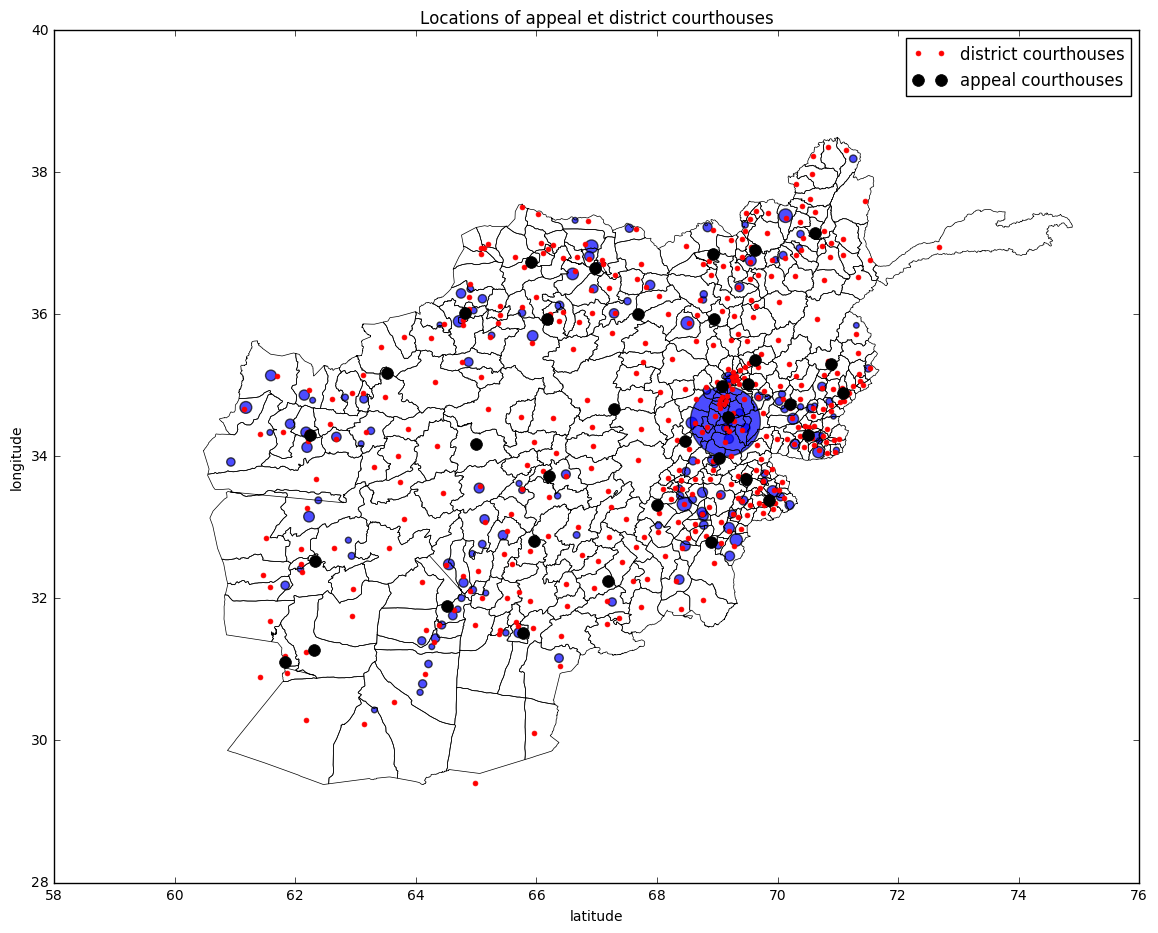

In [38]:
sf = shp.Reader("Afghanistan_Districts","rb")

#district=district[district['weight_lat']>0]
#region=region[region['weight_lat']>0]

region=region[region['LON_X']>0]
district=district[district['LAT_Y']>0]

plt.figure()
plt.figure(figsize=(14,11))


for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color='k',linewidth=0.5)


#plt.plot(data['LON_X'],data['LAT_Y'],alpha=0.7)
plt.scatter(bigtown_merged['LON_X_y'],bigtown_merged['LAT_Y_y'],s=bigtown_merged["weight_pop"],label="",alpha=0.7)    
plt.plot(district['weight_long'], district['weight_lat'],".r",label='district courthouses',ms=7)
plt.plot(region['weight_long'], region['weight_lat'],".k",label='appeal courthouses',ms=17)
plt.title("Locations of appeal et district courthouses")
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.legend(loc='best')
plt.show()